# LightGBM + ハイパーパラメータチューニング

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/classweight_submission_Logistic4.csv
../data/ozon_4_.ipynb
../data/sample_submit.csv
../data/smoto_submission_ensemble.csv
../data/smoto_submission_lightBGM.csv
../data/smoto_submission_Logistic.csv
../data/submission_ensemble.csv
../data/submission_lightBGM.csv
../data/submission_lightBGM2.csv
../data/submission_lightBGM2_2.csv
../data/submission_lightBGM3.csv
../data/submission_Logistic.csv
../data/submission_Logistic2.csv
../data/submission_Logistic3.csv
../data/sumote_submission_lightBGM_0516.csv
../data/sumoto_submission_Logistic2.csv
../data/sumoto_submission_Logistic3.csv
../data/sumoto_submission_Logistic3_2.csv
../data/sumoto_submission_Logistic3_3.csv
../data/sumoto_submission_Logistic4.csv
../data/sumoto_submission_Logistic4_2.csv
../data/test.tsv
../data/train.tsv
../data/.ipynb_checkpoints\ozon_4_-checkpoint.ipynb
../data/.ipynb_checkpoints\sample_submit-checkpoint.csv
../data/.ipynb_checkpoints\submission_ensemble-checkpoint.csv
../data/.ipynb_checkpoints\submissi

In [2]:
train_df = pd.read_table('../data/train.tsv', index_col='Date', parse_dates=True)
test_df = pd.read_table('../data/test.tsv', index_col='Date', parse_dates=True)
sample_sub = pd.read_csv('../data/sample_submit.csv')
print(sample_sub)

# set type label
train_df['type'] = 'train'
test_df['type'] = 'test'

# all data
all_df = pd.concat([train_df, test_df], axis=0)

      1267  0.0
0     1268  0.0
1     1269  0.0
2     1270  1.0
3     1271  1.0
4     1272  1.0
...    ...  ...
1261  2529  1.0
1262  2530  1.0
1263  2531  0.0
1264  2532  1.0
1265  2533  0.0

[1266 rows x 2 columns]


## 特徴量前処理

In [3]:
import re
from imblearn.over_sampling import SMOTE

def eda(all_df):
    # データの追加,気温・風速の標準偏差
    #1時間ごとの気温・風速を取得
    T_data = all_df[['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23']]
    WSR_data = all_df[['WSR0', 'WSR1', 'WSR2', 'WSR3', 'WSR4', 'WSR5', 'WSR6', 'WSR7', 'WSR8', 'WSR9', 'WSR10', 'WSR11', 'WSR12', 'WSR13', 'WSR14', 'WSR15', 'WSR16', 'WSR17', 'WSR18', 'WSR19', 'WSR20', 'WSR21', 'WSR22', 'WSR23']]
    # 行ごとの標準偏差を追加
    all_df['T_SD'] = T_data.std(axis=1)
    all_df['WSR_SD'] = WSR_data.std(axis=1)
    
    # データの削除, T0~T23
    all_df = all_df.drop(columns=['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23'])
    # データの削除, WSR0~WSR23
    all_df = all_df.drop(columns=['WSR0', 'WSR1', 'WSR2', 'WSR3', 'WSR4', 'WSR5', 'WSR6', 'WSR7', 'WSR8', 'WSR9', 'WSR10', 'WSR11', 'WSR12', 'WSR13', 'WSR14', 'WSR15', 'WSR16', 'WSR17', 'WSR18', 'WSR19', 'WSR20', 'WSR21', 'WSR22', 'WSR23'])
    
    # データの削除, SLP_
    all_df = all_df.drop(columns=['SLP_'])
    return all_df


# 特徴量の削除/追加
all_df = eda(all_df)

# trainとtestに分けなおす
train_df = all_df[all_df['type'] == 'train']
test_df = all_df[all_df['type'] == 'test']
# train正解ラベル
y = train_df['OZONE']

# 学習に不要な特徴量を削除
train_df = train_df.drop(columns=['id', 'OZONE', 'type'])
test_df = test_df.drop(columns=['id', 'OZONE', 'type'])

# 欠損値を平均値で補完
train_df = train_df.fillna(train_df.mean())
test_df = test_df.fillna(test_df.mean())


# オーバーサンプリング
# SMOTEの初期化と適用
smote = SMOTE(random_state=42)
train_df, y = smote.fit_resample(train_df, y)

"""
# データ標準化(rightGBMのときはいらない)
scaler = StandardScaler()
train_df = pd.DataFrame(scaler.fit_transform(train_df), index = train_df.index, columns = train_df.columns)
test_df = pd.DataFrame(scaler.transform(test_df), index = test_df.index, columns = test_df.columns)
"""

print(f'train_df : \n{train_df}\n')
print(f'y : \n{y}\n')

train_df : 
        WSR_PK    WSR_AV       T_PK       T_AV        T85      RH85       U85  \
0     5.500000  3.100000  19.100000  12.500000   6.700000  0.110000  3.830000   
1     5.500000  3.400000  22.400000  17.800000   9.000000  0.250000 -0.410000   
2     5.600000  3.500000  22.200000  18.700000   9.000000  0.560000  0.890000   
3     4.700000  3.200000  19.600000  18.700000   9.900000  0.890000 -0.340000   
4     3.700000  2.300000  26.000000  21.100000  13.539776  0.556758  2.243384   
...        ...       ...        ...        ...        ...       ...       ...   
2307  3.505226  1.610452  36.138711  30.464840  20.354388  0.352019 -3.826904   
2308  3.269236  1.659642  29.475985  23.469140  14.388468  0.244791  0.503609   
2309  3.491874  1.552032  34.565858  28.721953  20.086174  0.573414 -4.884639   
2310  4.203903  1.911575  28.646299  22.753970  12.996231  0.503082  3.625464   
2311  4.568205  2.090649  32.918703  26.109351  20.956983  0.277756 -1.719442   

            V85

### lightGBM
#### +ハイパーパラメータチューニング(深さ、葉数、学習率)

Fold : 0
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042832	valid_1's binary_logloss: 0.147164
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.042832	valid_1's binary_logloss: 0.147164
Fold : 1
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044877	valid_1's binary_logloss: 0.139415
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.044877	valid_1's binary_logloss: 0.139415
Fold : 2
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425069	valid_1's binary_logloss: 0.132821
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.0425069	valid_1's binary_logloss: 0.132821
Fold : 3
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0481036	valid_1's binary_logloss: 0.110723
Did not meet early stopping. Best 

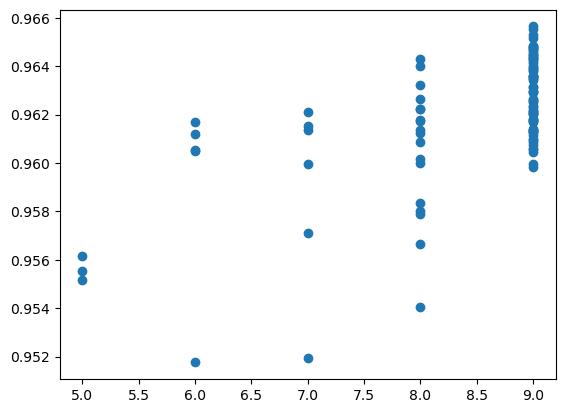

In [4]:
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
import optuna
optuna.logging.disable_default_handler() 

# indexをDateから普通のindexに直す(kholdが使えないため)、日付は消す
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

def objective(trial):
    #khold
    cv = KFold(n_splits=5, random_state=0, shuffle=True)

    # train_acc_list = []
    val_acc_list = []
    # models = []

    # ハイパーパラメータを定義　
    lgb_params = {
        "objective":"binary",
        # "metric": "binary_error",
        "metric": "binary_logloss",
        "force_row_wise" : True,
        "seed" : 0,
        'learning_rate': 0.1,
        "verbose_eval": 200,
        'verbosity': -1,

        # optunaでパラメータ探索する区間を指定
        #木の最大深度
        "max_depth": trial.suggest_int('max_depth', 5, 9),
        #一本の木の最大葉数
        "num_leaves": trial.suggest_int('num_leaves', 20, 51),
        #学習率
        "learning_rate": trial.suggest_float('learning_rate', 0.05, 0.1),
        }

    # KFold で学習させる
    for i ,(trn_index, val_index) in enumerate(cv.split(train_df, y)):

        print(f'Fold : {i}')
        X_train ,X_val = train_df.loc[trn_index], train_df.loc[val_index]
        y_train ,y_val = y[trn_index],y[val_index]

        # LigthGBM用のデータセットを定義
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_valid = lgb.Dataset(X_val, y_val)

        # model = lgb.train(params = lgb_params, train_set = lgb_train, valid_sets = [lgb_train, lgb_valid], callbacks=[lgb.log_evaluation(period=100), lgb.early_stopping(10)],)
        model = lgb.train(params = lgb_params, train_set = lgb_train, valid_sets = [lgb_train, lgb_valid], callbacks=[lgb.log_evaluation(period=100), lgb.early_stopping(10)],)

        y_pred = model.predict(X_train)

        """
        train_acc = accuracy_score(
            y_train, np.where(y_pred>=0.5, 1, 0)
            )

        train_acc_list.append(train_acc)
        """
        y_pred_val = model.predict(X_val)
        val_acc = balanced_accuracy_score(
            y_val, np.where(y_pred_val>=0.5, 1, 0)
            )
        
        val_acc_list.append(val_acc)

     # 最適化の指標にする値を返り値に設定
    return np.mean(val_acc_list)
    
# 最適化タスクを定義
optuna.logging.disable_default_handler()
# 引数のdirectionには最適化する指標を最大化したいのか、最小化したいのかを指定
study = optuna.create_study(direction="maximize")

# 最適化を実行します。この時の探索の試行回数をn_trialsで指定
study.optimize(objective, n_trials=100)

# 最適なパラメータとその時の精度を表示
print("best_value", study.best_value)
print("best_params", study.best_params)

# 最適化の過程を表示 & 可視化
optuna_log_df = study.trials_dataframe(attrs=("number", "value", "params"))
# display(optuna_log_df)

# max_depthと正答率の関係を可視化
plt.scatter(optuna_log_df["params_max_depth"], optuna_log_df["value"])

In [6]:
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

#khold
cv = KFold(n_splits=5, random_state=0, shuffle=True)

train_acc_list = []
val_acc_list = []
models = []
lgb_results = {}   # 学習の履歴を入れる入物

# ハイパーパラメータを定義　
lgb_params = {
    "objective":"binary",
    # "metric": "binary_error",
    "metric": "binary_logloss",
    "force_row_wise" : True,
    "seed" : 0,
    'learning_rate':0.09016793413343613,
    'num_leaves': 35,
    'max_depth': 9,
    "verbose_eval": 200,
    "verbose": -1,
    }

# indexをDateから普通のindexに直す(kholdが使えないため)、日付は消す
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# KFold で学習させる
for i ,(trn_index, val_index) in enumerate(cv.split(train_df, y)):
    
    print(f'Fold : {i}')
    X_train ,X_val = train_df.loc[trn_index], train_df.loc[val_index]
    y_train ,y_val = y[trn_index],y[val_index]
    
    # LigthGBM用のデータセットを定義
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_val, y_val)
    

    model = lgb.train(
        params = lgb_params,         # ハイパーパラメータをセット
        train_set = lgb_train,       # 訓練データを訓練用にセット
        valid_sets = [lgb_train, lgb_valid],   # 訓練データとテストデータをセット
        valid_names=['Train', 'Valid'],    # データセットの名前をそれぞれ設定
        callbacks=[lgb.log_evaluation(period=100),lgb.early_stopping(10), lgb.record_evaluation(lgb_results)], # アウトプット
    )
    
    y_pred = model.predict(X_train)
    print(f'y_pred.sum------------------------{np.where(y_pred>=0.5, 1, 0).sum()}')
    print(f'y_train.sum----------------------{y_train.sum()}')
    
    train_acc = balanced_accuracy_score(
        y_train, np.where(y_pred>=0.5, 1, 0)
        )
    print(train_acc)
    train_acc_list.append(train_acc)
    
    y_pred_val = model.predict(X_val)
    val_acc = balanced_accuracy_score(
        y_val, np.where(y_pred_val>=0.5, 1, 0)
        )
    print(val_acc)
    val_acc_list.append(val_acc)
    
    models.append(model)

print('-'*10 + 'Result' +'-'*10)
print(f'Train_acc : {train_acc_list} , Ave : {np.mean(train_acc_list)}')
print(f'Valid_acc : {val_acc_list} , Ave : {np.mean(val_acc_list)}')

Fold : 0
Training until validation scores don't improve for 10 rounds
[100]	Train's binary_logloss: 0.00368101	Valid's binary_logloss: 0.113737
Did not meet early stopping. Best iteration is:
[93]	Train's binary_logloss: 0.00506699	Valid's binary_logloss: 0.113038
y_pred.sum------------------------941
y_train.sum----------------------941.0
1.0
0.9705363840960239
Fold : 1
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[88]	Train's binary_logloss: 0.00802403	Valid's binary_logloss: 0.117057
y_pred.sum------------------------916
y_train.sum----------------------916.0
1.0
0.9575579222720478
Fold : 2
Training until validation scores don't improve for 10 rounds
[100]	Train's binary_logloss: 0.00429592	Valid's binary_logloss: 0.107333
Did not meet early stopping. Best iteration is:
[97]	Train's binary_logloss: 0.00492481	Valid's binary_logloss: 0.106862
y_pred.sum------------------------938
y_train.sum----------------------938.0
1.0
0.964919536

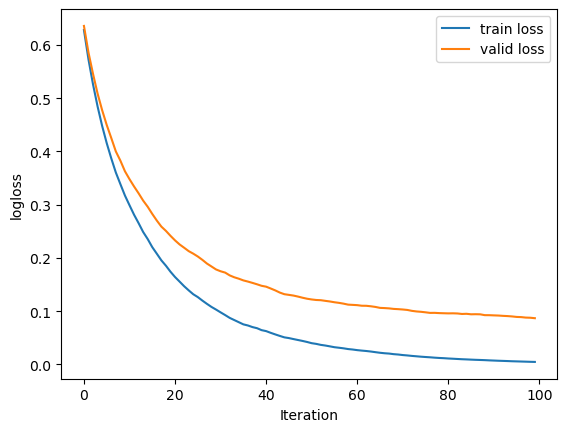

In [8]:
loss_train = lgb_results['Train']['binary_logloss']
loss_valid = lgb_results['Valid']['binary_logloss']   
  
fig = plt.figure()
ax1 = fig.add_subplot(111)
  
ax1.set_xlabel('Iteration')
ax1.set_ylabel('logloss')
 
ax1.plot(loss_train, label='train loss')
ax1.plot(loss_valid, label='valid loss')
 
plt.legend()
plt.show()

In [11]:
# モデルを用いてテストデータを予測
test_pred = np.zeros((len(test_df), 5))
for fold_index , gbm in enumerate(models):
    pred_test = gbm.predict(test_df)
    print(np.where(pred_test>=0.5, 1, 0).sum())
    # test_pred[:, fold_index] = pred_test
    test_pred[:, fold_index] = np.where(pred_test>=0.5, 1, 0)

# 行数で繰り返し予測値を代入
test_pred = pd.DataFrame(test_pred)
test_pred = test_pred.mode(axis=1).values
print(f'test_pred.sum : {test_pred.sum()}')
for index, row in sample_sub.iterrows():
    sample_sub.iloc[index,1] = test_pred[index]
    
# 結果を保存
# sample_sub.to_csv("../data/submission_lightBGM.csv", index=False)
# sample_sub.to_csv("../data/smoto_submission_lightBGM.csv", index=False)
sample_sub.to_csv("../data/smoto_submission_lightBGM_0516_2.csv", index=False)

84
85
82
89
79
test_pred.sum : 84.0
